# Part A

### 1. Project environment & packages

In [1]:
using Pkg
Pkg.activate("..")

using DrWatson
@quickactivate "FE2P1SvobodaVlach"

  Activating project at `~/Library/CloudStorage/OneDrive-FSV/IES_mgr/Financial Ecox II/Projects/FE2P1SvobodaVlach`


In [2]:
#Pkg.add("MarketData")
#Pkg.add("Dates")
#Pkg.add("DataFrames")
Pkg.add("StatsPlots")
Pkg.add("ARCHModels")


using MarketData
using Dates
using DataFrames
using StatsPlots
using ARCHModels

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed Distances ────────── v0.10.12
   Installed Libgpg_error_jll ─── v1.50.0+0
   Installed XZ_jll ───────────── v5.6.3+0
   Installed MLDataDevices ────── v1.4.2
   Installed KernelAbstractions ─ v0.9.29
   Installed LLVM ─────────────── v9.1.3
   Installed Zygote ───────────── v0.6.72
   Installed XML2_jll ─────────── v2.13.4+0
   Installed Libgcrypt_jll ────── v1.11.0+0
   Installed Libiconv_jll ─────── v1.17.0+1
   Installed Transducers ──────── v0.4.84
   Installed Flux ─────────────── v0.14.22
  No Changes to `~/Library/CloudStorage/OneDrive-FSV/IES_mgr/Financial Ecox II/Projects/FE2P1SvobodaVlach/Project.toml`
  No Changes to `~/Library/CloudStorage/OneDrive-FSV/IES_mgr/Financial Ecox II/Projects/FE2P1SvobodaVlach/Manifest.toml`
Precompiling project...
  ✓ EpollShim_jll
  ✓ Libmount_jll
  ✓ Xorg_libXau_jll
  ✓ IntelOpenMP_jll
  ✓ Xorg_libICE_jll
  ✓ mtdev_jll
  ✓ Xorg_libXdmcp_jl

In [3]:
Pkg.add("GLM")
Pkg.add("Plots")
Pkg.add("Random")

using GLM 
using Plots 
using Random 

   Resolving package versions...
  No Changes to `~/Library/CloudStorage/OneDrive-FSV/IES_mgr/Financial Ecox II/Projects/FE2P1SvobodaVlach/Project.toml`
  No Changes to `~/Library/CloudStorage/OneDrive-FSV/IES_mgr/Financial Ecox II/Projects/FE2P1SvobodaVlach/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Library/CloudStorage/OneDrive-FSV/IES_mgr/Financial Ecox II/Projects/FE2P1SvobodaVlach/Project.toml`
  No Changes to `~/Library/CloudStorage/OneDrive-FSV/IES_mgr/Financial Ecox II/Projects/FE2P1SvobodaVlach/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Library/CloudStorage/OneDrive-FSV/IES_mgr/Financial Ecox II/Projects/FE2P1SvobodaVlach/Project.toml`
  No Changes to `~/Library/CloudStorage/OneDrive-FSV/IES_mgr/Financial Ecox II/Projects/FE2P1SvobodaVlach/Manifest.toml`


In [4]:
Pkg.add("Flux")
Pkg.add("Optim")
Pkg.add("Statistics")

using Flux 
using Optim 
using Statistics 

   Resolving package versions...
  No Changes to `~/Library/CloudStorage/OneDrive-FSV/IES_mgr/Financial Ecox II/Projects/FE2P1SvobodaVlach/Project.toml`
  No Changes to `~/Library/CloudStorage/OneDrive-FSV/IES_mgr/Financial Ecox II/Projects/FE2P1SvobodaVlach/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Library/CloudStorage/OneDrive-FSV/IES_mgr/Financial Ecox II/Projects/FE2P1SvobodaVlach/Project.toml`
  No Changes to `~/Library/CloudStorage/OneDrive-FSV/IES_mgr/Financial Ecox II/Projects/FE2P1SvobodaVlach/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Library/CloudStorage/OneDrive-FSV/IES_mgr/Financial Ecox II/Projects/FE2P1SvobodaVlach/Project.toml`
  No Changes to `~/Library/CloudStorage/OneDrive-FSV/IES_mgr/Financial Ecox II/Projects/FE2P1SvobodaVlach/Manifest.toml`


### 2. Download data for Apple

In [5]:
ticker = "AAPL"

start_date = DateTime(2023, 1, 1)
stop_date = DateTime(2024, 1, 1)

2024-01-01T00:00:00

In [6]:
data_apple = DataFrame(yahoo(ticker, YahooOpt(period1 = start_date, period2 = stop_date)));

### 3. Summary statistics & plots

In [7]:
first(data_apple, 3)

Row,timestamp,Open,High,Low,Close,AdjClose,Volume
,Date,Float64,Float64,Float64,Float64,Float64,Float64
1,2023-01-03,130.28,130.9,124.17,125.07,123.905,1.12118e8
2,2023-01-04,126.89,128.66,125.08,126.36,125.183,8.91136e7
3,2023-01-05,127.13,127.77,124.76,125.02,123.855,8.09627e7


In [8]:
typeof(data_apple)

DataFrame

In [9]:
size(data_apple)

(250, 7)

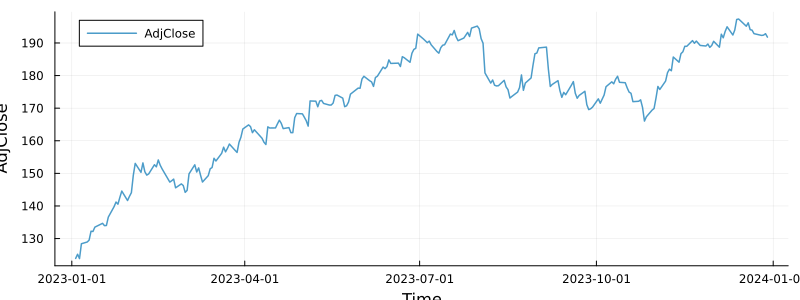

In [10]:
plot(data_apple.timestamp, data_apple.AdjClose, 
    line=(1.5, 0.7, :solid), size=(800,300), palette=:seaborn_colorblind,
    label="AdjClose", xlabel="Time", ylabel="AdjClose") # TODO: Proc se nevejdou axis labels??

# savefig(plotsdir("apple_adjclose.png")) # Save to "plots/"

In [11]:
summary_stats = describe(data_apple[:, :AdjClose])

Summary Stats:
Length:         250
Missing Count:  0
Mean:           171.470441
Std. Deviation: 17.437952
Minimum:        123.855087
1st Quartile:   160.847198
Median:         174.581650
3rd Quartile:   186.470261
Maximum:        197.361084
Type:           Float64


### 4. Model & forecast

In [12]:
# Parameters
pred_length = 10 # Number of predictions

10

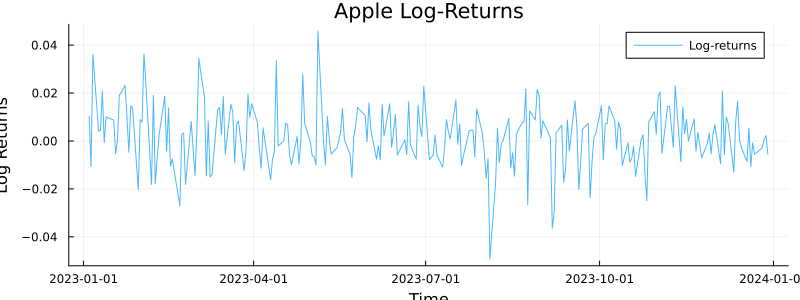

In [13]:
# Log-returns
ret_apple = DataFrame(
    returns = diff(log.(data_apple[:, :AdjClose])),
    timestamp = data_apple.timestamp[2:end]
)

plot(ret_apple.timestamp, ret_apple.returns,
    line=(1, 0.7), size=(800,300),
    xlabel="Time", ylabel="Log Returns",
    title="Apple Log-Returns", label="Log-returns"
)

# savefig(plotsdir("apple_logreturns.png")) # Save to "plots/"

In [14]:
# Autocoorelation function -> used on prices or returns???
plot(autocor(ret_apple.returns, 1:20),
    seriestype=:bar, 
    xlabel="Lag", 
    ylabel="Autocorrelation",
    title="Autocorrelation Function for Apple Returns")

savefig(plotsdir("apple_autocor.png")) # Save to "plots/"

"/Users/tomassvoboda/Library/CloudStorage/OneDrive-FSV/IES_mgr/Financial Ecox II/Projects/FE2P1SvobodaVlach/plots/apple_autocor.png"

In [15]:
# Train-test split
train_apple = ret_apple[1:end-pred_length, :]
test_apple = ret_apple[end-pred_length+1:end, :]

Row,returns,timestamp
,Float64,Date
1,-0.00272943,2023-12-15
2,-0.00853965,2023-12-18
3,0.00534578,2023-12-19
4,-0.0107717,2023-12-20
5,-0.000770337,2023-12-21
6,-0.00556283,2023-12-22
7,-0.00284507,2023-12-26
8,0.00051788,2023-12-27
9,0.00222378,2023-12-28


In [16]:
# Fit
garch_fit = fit(GARCH{1,1}, train_apple.returns)


GARCH{1, 1} model with Gaussian errors, T=239.

Mean equation parameters:
────────────────────────────────────────────
    Estimate    Std.Error  z value  Pr(>|z|)
────────────────────────────────────────────
μ  0.0019609  0.000832065  2.35667    0.0184
────────────────────────────────────────────

Volatility parameters:
──────────────────────────────────────────────
      Estimate   Std.Error   z value  Pr(>|z|)
──────────────────────────────────────────────
ω   8.97302e-6  1.86888e-5  0.480127    0.6311
β₁  0.936011    0.128395    7.29011     <1e-12
α₁  0.00649415  0.031429    0.206629    0.8363
──────────────────────────────────────────────


In [20]:
garch_pred = predict.(garch_fit, :variance, 1:pred_length)

10-element Vector{Float64}:
 0.00015029184921420106
 0.00015062389821827315
 0.00015093685620420956
 0.00015123182080208593
 0.00015150982653419734
 0.0001517718484434137
 0.00015201880551292431
 0.00015225156388936568
 0.00015247093992063696
 0.00015267770301905745

### 5. Forecasts plot

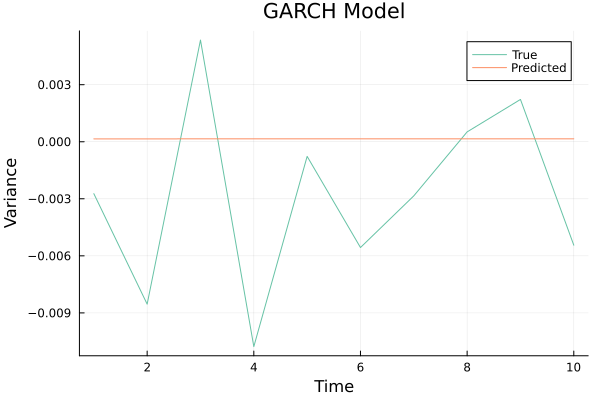

In [26]:
p1 = plot(test_apple.returns, lab="True", leg=:topright, title="GARCH Model", palette=:Set2_3, xlabel="Time", ylabel="Variance",)
p1 = plot!(garch_pred, lab="Predicted") # TODO: Apple returns -> variance

#savefig(plotsdir("apple_garch.png")) # Save to "plots/"

# Part B

In [58]:
""" Create HAR regressors """
function HAR_regressors(data)

    RVd = data[22:end-1] # days
    RVw = zeros(length(RVd)) # weeks
    for i in 22:(length(data)-1)
       temp = 0
       for h in 0:4
           temp = temp + data[i-h]
       end
       RVw[i-21]= temp / 5
    end
    
    RVm = zeros(length(RVd)) # months
    for i in 22:(length(data)-1) 
       temp = 0
       for h in 0:21
           temp = temp + data[i-h]
       end
       RVm[i-21] = temp / 22;
    end

    return [RVd RVw RVm]
end

HAR_regressors

In [57]:
function OLSestimatorconst(y,x)
    x = [ones(size(x)[1]) x]
    return (transpose(x) * x) \ (transpose(x) * y)
end

OLSestimatorconst (generic function with 1 method)

In [67]:
OLSestimatorconst(train_apple[23:end,1], HAR_regressors(train_apple[:,1]))

4-element Vector{Float64}:
  0.0016350329267192274
  0.07532152978070221
 -0.13492955560457245
 -0.2392764017435208